<a href="https://colab.research.google.com/github/OscarAlvaradoM/Introduccion-al-Aprendizaje-Profundo/blob/main/tarea2/Tarea2_P2_IAP_OscarAlvardo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio 2
Extiende la libreta `2b_comida_inception.ipynb` para implementar y entrenar la arquitectura tipo ResNet que se especifica en la Figura 1.

<img src="https://raw.githubusercontent.com/OscarAlvaradoM/Introduccion-al-Aprendizaje-Profundo/main/figs/resnet.png"/>

## Preparación del entorno

In [2]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

## Importando bibliotecas

In [3]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange
# imágenes
from PIL import Image

## Para utilizar la GPU

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Algunas funciones y caminos auxiliares

In [5]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/e4dZiWt2bZCGWQ9/download'
base_dir = '../datos/recipes'
filename = 'recipes2k.tar.gz'
data_dir = '../datos/recipes/recipes2k'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 64


def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


# reproducibilidad
set_seed()

## Descarga de `Recipes2k`

In [6]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

--2021-05-11 16:30:25--  https://cloud.xibalba.com.mx/s/e4dZiWt2bZCGWQ9/download
Resolving cloud.xibalba.com.mx (cloud.xibalba.com.mx)... 187.189.27.18
Connecting to cloud.xibalba.com.mx (cloud.xibalba.com.mx)|187.189.27.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93675898 (89M) [application/x-gzip]
Saving to: ‘../datos/recipes/recipes2k.tar.gz’

../datos/recipes/re 100%[===================>]  89.34M  15.9MB/s    in 6.2s    

2021-05-11 16:30:32 (14.4 MB/s) - ‘../datos/recipes/recipes2k.tar.gz’ saved [93675898/93675898]



## Muestra de los datos

In [7]:
df = pd.read_csv(os.path.join(data_dir, 'trn.csv'), index_col='item')
df.head()

,healthy,junk,dessert,appetizer,mains,soups,carbs,protein,fats,meat
item,,,,,,,,,,
apple_pie,0,0,1,0,0,0,1,0,1,0
baby_back_ribs,0,0,0,0,1,0,0,1,1,1
beef_tacos,0,0,0,0,1,0,1,1,1,1
beet_salad,1,0,0,0,1,0,0,1,0,0
bread_pudding,0,0,1,0,0,0,1,0,1,0


## Muestra de la carpeta de entrenamiento

In [8]:
! ls {data_dir}/trn/beet_salad | head -5

0_maple_roasted_beet_and_goat_cheese_salad.jpg
10_balsamic_beet_salad_with_arugula_and_goat_cheese.jpg
11_roasted_beet_and_goat_cheese_salad.jpg
12_cathys_bodacious_beet_salad.jpg
13_red_beet_salad.jpg


## Objeto `Recipes`

In [9]:
class RecipesDS:

    def __init__(self, root, tsfm):
        
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        
        # leemos el dataframe y filtramos columna healthy
        df = pd.read_csv(os.path.join(root, 'trn.csv'), index_col='item')
        df = df['healthy']
        
        # direcorios superiores
        base_dir = os.path.join(root, 'trn')
        classes = sorted(os.listdir(base_dir))
        
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        
        # por cada clase
        for clazz in classes:
            # directorio de la clase
            class_dir = os.path.join(base_dir, clazz)
            # nombres de los archivos en el directorio de la clase
            names = sorted(os.listdir(class_dir))
            # guardamos los rutas y las etiquetas
            for name in names:
                self.paths.append(os.path.join(class_dir, name))
                self.labels.append(df.loc[clazz])

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

## Exploración de los datos

x shape=torch.Size([32, 64, 64, 3]) dtype=torch.uint8
y shape=torch.Size([32, 1]) dtype=torch.float32


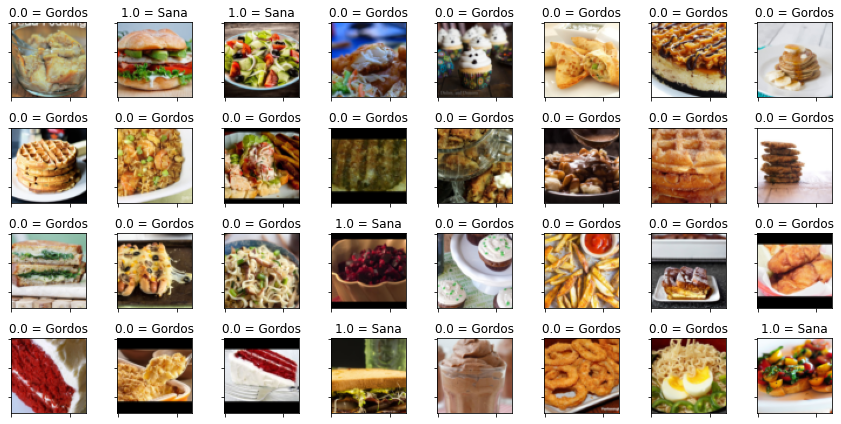

In [10]:
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # convertimos a ndarray
    np.array
])

ds = RecipesDS(data_dir, tsfm)

dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} = Sana' if l else f'{l.item()} = Gordos' for l in y]
display_grid(x, titles, ROWS, COLS)

## Cargador de los datos

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


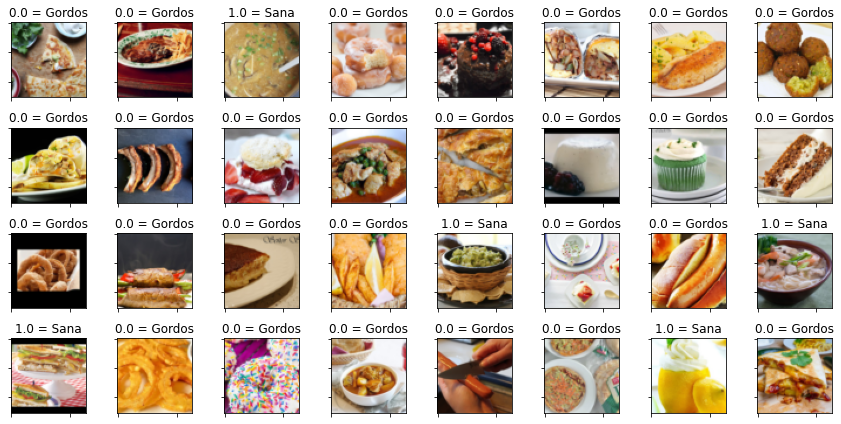

In [11]:
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor(),
])

trn_ds = RecipesDS(data_dir, tsfm)

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} = Sana' if l else f'{l.item()} = Gordos' for l in y]
display_batch(x, titles, ROWS, COLS)

## Definiendo arquitectura

In [12]:
class ResNetBlock(nn.Module):
    # La inicialización de nuestro bloque ResNet
    def __init__(self, in_channels, out_channels_izquierda, out_channels_derecha):
        super(ResNetBlock, self).__init__()
        # Se tienen 2 valores de salida, entonces descomponemos aquí
        out_channels11, out_channels12 = out_channels_izquierda
        
        # Definimos nuestra bifurcación de la izquierda. Como una secuencial de convolución, normalización por 
        # lotes, función de activación y luego lo mismo otra vez. 
        self.bifurcacion_izquierda = nn.Sequential(
            # Convolucional 1
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels11, 
                      kernel_size=3, padding=1, stride=1),
            # Batch Normalization 1
            nn.BatchNorm2d(out_channels11),
            # Función de activación 1
            nn.ReLU(),
            
            # Convolucional 1
            nn.Conv2d(in_channels=out_channels11, out_channels=out_channels12, 
                      kernel_size=3, padding=1, stride=1),
            # Batch Normalization 1
            nn.BatchNorm2d(out_channels12),
            # Función de activación 1
            nn.ReLU()
        )
        # Definimos la bifurcación de la derecha sólo con una capa convolucional.
        self.bifurcacion_derecha = nn.Conv2d(in_channels=in_channels, out_channels=out_channels_derecha,
                                            kernel_size=1, padding=0, stride=1)
    def forward(self,x):
        # Aquí juntamos las dos bifurcaciones! 
        x_i = self.bifurcacion_izquierda(x)
        x_d = self.bifurcacion_derecha(x)
        x = torch.cat([x_i,x_d],1)
        return x

### Instanciamos un modelo y vemos su arquitectura

In [13]:
block = ResNetBlock(in_channels=3, 
                    out_channels_izquierda=(4,4),
                    out_channels_derecha=4)
block

ResNetBlock(
  (bifurcacion_izquierda): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (bifurcacion_derecha): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
)

### Prueba con datos sintéticos sobre el bloque

In [14]:
x = torch.zeros(1, 3, 64, 64)
y = block(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 64, 64]) => torch.Size([1, 8, 64, 64])


## Creando la ResNet dado un bloquecito.

In [15]:
class MicroResNet(nn.Module):
    def __init__(self):
        super(MicroResNet, self).__init__()
        # Formamos la arquitectura de nuestra red. No usamos esto de secuencial ya que son varias capas y 
        # así sería más fácil checar donde está algún error en algún paso. 
        
        # Instanciamos un bloque ResNet
        self.rn1 = ResNetBlock(in_channels=3, out_channels_izquierda=(4,4), out_channels_derecha=4)
        # Hacemos un MaxPooling
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Instanciamos otro bloque ResNet
        self.rn2 = ResNetBlock(in_channels=8, out_channels_izquierda=(4,4), out_channels_derecha=4)
        # De nuevo un Max Pool
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Finalmente aplanamos
        self.flatten = nn.Flatten()
        # Construimos las dimensiones del vector ya aplanado
        self.num_feats = 8*16*16
        # Continuamos con la clasificación dadas ciertas dimensiones.
        self.cls = nn.Linear(self.num_feats, 1)
        
    def forward(self, x):
        # Aquí pegamos cada paso para los datos.
        x = self.rn1(x)
        x = self.pool1(x)
        x = self.rn2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.cls(x)
        return x

### Creamos un modelo y visualizamos su arquitectura

In [16]:
model = MicroResNet()
model

MicroResNet(
  (rn1): ResNetBlock(
    (bifurcacion_izquierda): Sequential(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (bifurcacion_derecha): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rn2): ResNetBlock(
    (bifurcacion_izquierda): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, tr

### Probamos con datos sintéticos

In [17]:
x = torch.zeros(1, 3, 64, 64)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 64, 64]) => torch.Size([1, 1])


### Inspección del modelo 

In [18]:
summary(model, (1, 3, 64, 64), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
MicroResNet                              --                        --
├─ResNetBlock: 1-1                       [1, 8, 64, 64]            --
│    └─Sequential: 2-1                   [1, 4, 64, 64]            --
│    │    └─Conv2d: 3-1                  [1, 4, 64, 64]            112
│    │    └─BatchNorm2d: 3-2             [1, 4, 64, 64]            8
│    │    └─ReLU: 3-3                    [1, 4, 64, 64]            --
│    │    └─Conv2d: 3-4                  [1, 4, 64, 64]            148
│    │    └─BatchNorm2d: 3-5             [1, 4, 64, 64]            8
│    │    └─ReLU: 3-6                    [1, 4, 64, 64]            --
│    └─Conv2d: 2-2                       [1, 4, 64, 64]            16
├─MaxPool2d: 1-2                         [1, 8, 32, 32]            --
├─ResNetBlock: 1-3                       [1, 8, 32, 32]            --
│    └─Sequential: 2-3                   [1, 4, 32, 32]            --
│    │    └─Con

## Entrenamiento en GPU

In [19]:
def train_epoch_GPU(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x.to(device))
        
        # computamos la pérdida
        loss = F.binary_cross_entropy_with_logits(y_lgts, y_true.to(device))
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch_GPU(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x.to(device))

            # computamos los puntajes
            y_prob = torch.sigmoid(y_lgts)
            
            # computamos las clases
            y_pred = torch.round(y_prob)

            # computamos la pérdida
            loss = F.binary_cross_entropy_with_logits(y_lgts, y_true.to(device))

            # computamos la exactitud
            acc = (y_true.to(device) == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train_GPU(model, trn_dl, lr=1e-1, epochs=15,
          trn_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch_GPU(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch_GPU(trn_dl, model, trn_batches)

        # guardamos historial
        loss_hist.append(trn_loss)
        acc_hist.append(trn_acc)

        # imprimimos progreso
        print(f'E{epoch:02} loss={trn_loss:6.2f} acc={trn_acc:5.2f}')

    return loss_hist, acc_hist

## Instanciado y entrenamiento del modelo

In [20]:
model = MicroResNet()
loss_hist, acc_hist = train_GPU(model.to(device), trn_dl, epochs=14)

E00 loss= 49.67 acc=78.92
E01 loss= 48.29 acc=80.28
E02 loss= 51.11 acc=79.37
E03 loss= 44.76 acc=80.27
E04 loss= 43.40 acc=80.78
E05 loss= 43.81 acc=81.99
E06 loss= 42.69 acc=82.86
E07 loss= 40.62 acc=81.76
E08 loss= 36.73 acc=83.68
E09 loss= 40.53 acc=82.78
E10 loss= 34.64 acc=86.05
E11 loss= 32.27 acc=86.52
E12 loss= 38.54 acc=84.85
E13 loss= 31.21 acc=87.36



## Muesta de resultados

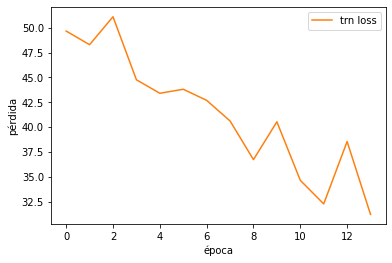

In [21]:
plt.plot(loss_hist, 'tab:orange', label='trn loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

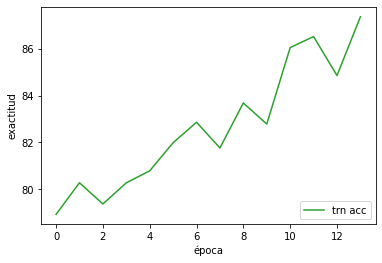

In [22]:
plt.plot(acc_hist, 'tab:green', label='trn acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [25]:
model = MicroResNet()
loss_hist, acc_hist = train_GPU(model.to(device), trn_dl, epochs=30)

E00 loss= 48.42 acc=79.48
E01 loss= 48.53 acc=80.32
E02 loss= 45.01 acc=80.27
E03 loss= 44.03 acc=79.70
E04 loss= 41.58 acc=81.47
E05 loss= 44.11 acc=81.73
E06 loss= 41.37 acc=84.01
E07 loss= 38.89 acc=83.19
E08 loss= 46.78 acc=79.47
E09 loss= 39.45 acc=83.04
E10 loss= 35.48 acc=85.07
E11 loss= 34.78 acc=86.05
E12 loss= 32.31 acc=86.49
E13 loss= 35.57 acc=84.60
E14 loss= 34.77 acc=85.36
E15 loss= 35.69 acc=83.99
E16 loss= 31.22 acc=86.49
E17 loss= 29.34 acc=87.43
E18 loss= 27.37 acc=88.81
E19 loss= 33.69 acc=86.23
E20 loss= 25.09 acc=88.92
E21 loss= 24.75 acc=89.21
E22 loss= 28.81 acc=88.30
E23 loss= 22.05 acc=92.12
E24 loss= 19.35 acc=93.06
E25 loss= 18.25 acc=93.32
E26 loss= 24.36 acc=89.76
E27 loss= 18.05 acc=92.63
E28 loss= 16.25 acc=93.64
E29 loss= 28.30 acc=88.45



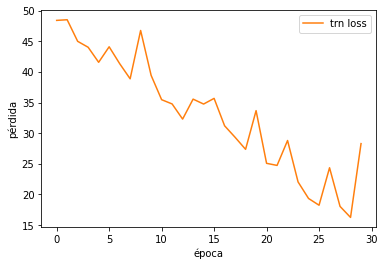

In [26]:
plt.plot(loss_hist, 'tab:orange', label='trn loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

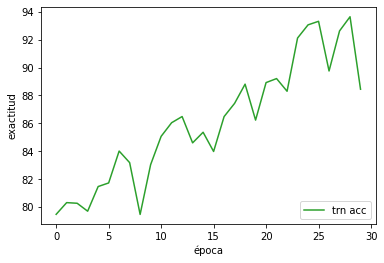

In [27]:
plt.plot(acc_hist, 'tab:green', label='trn acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## Probando con datos ajenos

In [23]:
# cargamos imágenes de prueba
imgs = []
tst_dir = os.path.join(data_dir, 'tst')
names = sorted(os.listdir(tst_dir))
for name in names:
    path = os.path.join(tst_dir, name)
    img = io.imread(path)
    size = min(*img.shape[:2])
    img = crop_center(img, size, size)
    img = resize(img, (IMG_SIZE, IMG_SIZE))
    imgs.append(img)

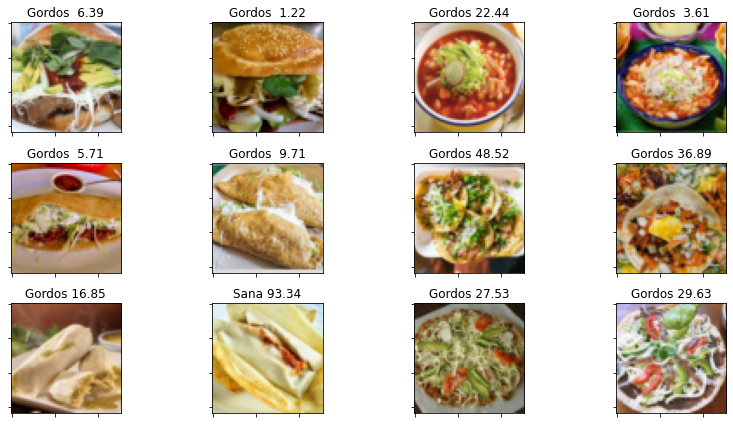

In [24]:
# desplegamos con probas
titles = []
with torch.no_grad():
    for img in imgs:
        img_torch = numpy_to_torch(img)
        img_torch = img_torch.unsqueeze(0)
        prob = torch.sigmoid(model(img_torch.to(device)).to(device))
        prob = prob.item() * 100
        if prob < 50:
            titles.append(f'Gordos {prob:5.2f}')
        else:
            titles.append(f'Sana {prob:5.2f}')

display_grid(imgs, titles, 3, 4)

Vemos que se obtienen mejores resultados que los que se obtuvieron con la red Inception. Notamos que las gráficas muestran un comportamiento de mejora en el entrenamiento, se alcanzan mejores resultados mientras más se avanza con las épocas, cosa que no presentaba el modelo de inception, que se quedaba para en un valor desde el principio, con una exactitud de al rededor de 70. Ciertamente es una arquitectura más compleja pero creo que agarrando la onda con esto de formar bloques y luego pegarlos secuencialmente se pueden hacer arquitecturas más complejas sin tanta dificultad. Parece que para esta arquitectura se tiene que la verdurita que le ponen a este tipo de cosas sí le da un peso más grande hacia ser saludable respecto a la arquitectura Inception. ¿Cómo que los tacos no son saludables? :( 